In [2]:
import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
import scipy as sp
import cv2

In [3]:
dataset_name = "oxford_iiit_pet"
(train_data, test_data), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)

In [4]:
train_ds_length = tf.data.experimental.cardinality(train_data).numpy()
test_ds_length = tf.data.experimental.cardinality(test_data).numpy()

print(train_ds_length)
print(test_ds_length)

3680
3669


In [5]:
NUM_CLASSES = ds_info.features["label"].num_classes

In [6]:
print(NUM_CLASSES)

37


In [7]:
def augment_images(image, label):

  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image / 255)
  label = tf.one_hot(label, NUM_CLASSES)
  # resize to 300x300
  image = tf.image.resize(image, (300, 300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

In [8]:
model = Sequential()
model.add(Conv2D(16, input_shape=(300, 300, 3), kernel_size=(3, 3),
                 activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(GlobalAveragePooling2D())
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 64)        0

In [9]:
# configure the training
model.compile(loss="categorical_crossentropy",
              metrics=["accuracy"],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

# train the model. just run a few epochs for this test run. you can adjust later.
model.fit(train_batches, batch_size=32, epochs = 30)

Epoch 1/30
115/115 [==============================] - 23s 109ms/step - loss: 3.6115 - accuracy: 0.0280
Epoch 2/30
115/115 [==============================] - 16s 115ms/step - loss: 3.5904 - accuracy: 0.0353
Epoch 3/30
115/115 [==============================] - 14s 92ms/step - loss: 3.5430 - accuracy: 0.0418
Epoch 4/30
115/115 [==============================] - 16s 110ms/step - loss: 3.5144 - accuracy: 0.0519
Epoch 5/30
115/115 [==============================] - 16s 111ms/step - loss: 3.4969 - accuracy: 0.0603
Epoch 6/30
115/115 [==============================] - 16s 111ms/step - loss: 3.4872 - accuracy: 0.0617
Epoch 7/30
115/115 [==============================] - 15s 100ms/step - loss: 3.4701 - accuracy: 0.0655
Epoch 8/30
115/115 [==============================] - 16s 107ms/step - loss: 3.4576 - accuracy: 0.0663
Epoch 9/30
115/115 [==============================] - 14s 102ms/step - loss: 3.4428 - accuracy: 0.0712
Epoch 10/30
115/115 [==============================] - 15s 105ms/step - lo

In [10]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model = Model(inputs=model.input,
                  outputs=(model.layers[-3].output,
                           model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496 

In [25]:
def show_cam(image_value, features, results):
  """
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  """

  # there is only one image in the batch so we index as `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:, 0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)

  cam_output = np.dot(class_activation_features, class_activation_weights)

  # visualize the results
  print(f"softmax output: {results}")
  print("prediction : ", ds_info.features["label"].int2str( ( np.argmax( results[0] ) ) ) )
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()

In [26]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)

  # generate the CAM
  show_cam(tensor_image, features, results)

In [27]:
!wget -O dog1.jpg https://hips.hearstapps.com/hmg-prod/images/large-cat-breed-maine-coon-1553270773.jpg?crop=1xw:1xh;center,top&resize=980:*
!wget -O dog2.jpg https://hips.hearstapps.com/hmg-prod/images/savannah-cat-royalty-free-image-1011241372-1553192150.jpg?crop=0.447xw:1.00xh;0.322xw,0&resize=980:*
!wget -O dog3.jpg https://hips.hearstapps.com/hmg-prod/images/portrait-of-siberian-cat-sitting-outdoors-royalty-free-image-559162229-1553192176.jpg?crop=0.815xw:1.00xh;0,0&resize=980:*
!wget -O dog4.jpg https://hips.hearstapps.com/hmg-prod/images/norwegian-forest-cat-royalty-free-image-990019846-1553192205.jpg?crop=0.447xw:1.00xh;0.381xw,0&resize=980:*
!wget -O dog5.jpg https://hips.hearstapps.com/hmg-prod/images/ragdoll-cat-with-intense-blue-eyes-royalty-free-image-107791319-1553192229.jpg?crop=0.432xw:0.974xh;0.446xw,0.00512xh&resize=980:*
!wget -O dog6.jpg https://hips.hearstapps.com/hmg-prod/images/ragamuffin-cat-1553270111.jpg?crop=0.7068676716917922xw:1xh;center,top&resize=980:*
!wget -O dog7.jpg https://hips.hearstapps.com/hmg-prod/images/chausie-abyssinian-cat-on-dark-brown-background-royalty-free-image-837639058-1553192486.jpg?crop=0.447xw:1.00xh;0.397xw,0&resize=980:*

--2024-04-24 13:18:29--  https://hips.hearstapps.com/hmg-prod/images/large-cat-breed-maine-coon-1553270773.jpg?crop=1xw:1xh
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407180 (398K) [image/jpeg]
Saving to: ‘dog1.jpg’

dog1.jpg            100%[===================>] 397.64K  --.-KB/s    in 0.01s   

2024-04-24 13:18:29 (29.7 MB/s) - ‘dog1.jpg’ saved [407180/407180]

/bin/bash: line 1: center,top: command not found
--2024-04-24 13:18:29--  https://hips.hearstapps.com/hmg-prod/images/savannah-cat-royalty-free-image-1011241372-1553192150.jpg?crop=0.447xw:1.00xh
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting respon

In [28]:
ds_info.features["label"].int2str(26)

'Ragdoll'

In [ ]:
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')
convert_and_classify('dog3.jpg')
convert_and_classify('dog4.jpg')
convert_and_classify('dog5.jpg')
convert_and_classify('dog6.jpg')
convert_and_classify('dog7.jpg')

In [36]:
!wget -O temp.jpg https://www.thesprucepets.com/thmb/vBnvhvkhk0SwnYYVdxVO8cI9i04=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/egytpian-mau-8cfcee0c70eb41929d448e55afa7d96c.jpg

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `wget -O temp.jpg https://www.thesprucepets.com/thmb/vBnvhvkhk0SwnYYVdxVO8cI9i04=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/egytpian-mau-8cfcee0c70eb41929d448e55afa7d96c.jpg'


1/1 [==============================] - 0s 30ms/step
softmax output: [[0.01287553 0.01336277 0.00902107 0.00602024 0.01035491 0.01324802
  0.03469008 0.0048765  0.01672779 0.10127687 0.01040865 0.03902369
  0.01902914 0.02596976 0.01158543 0.02007699 0.04126538 0.03564237
  0.06724729 0.01750715 0.03011734 0.00699635 0.01154619 0.02228468
  0.02838042 0.05029036 0.0342669  0.11223925 0.02194382 0.03082201
  0.01218645 0.01539052 0.03308948 0.00728734 0.00871955 0.04651695
  0.0177128 ]]
prediction :  Russian_Blue


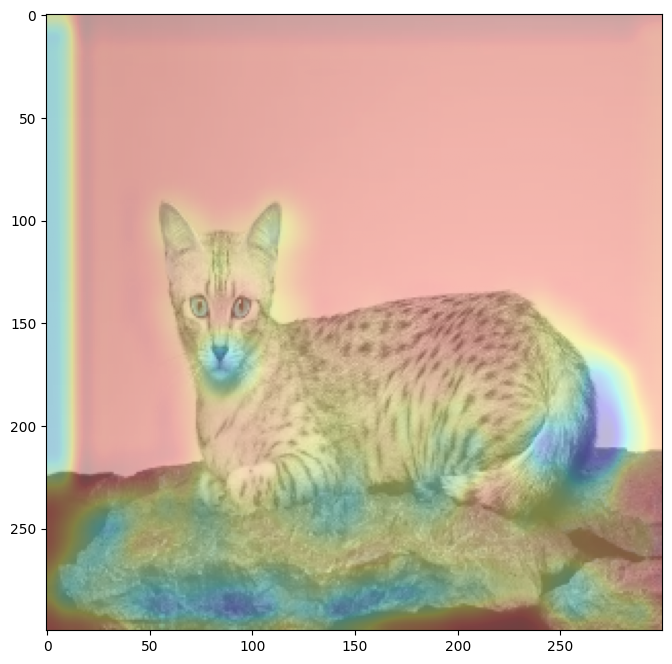

In [37]:
convert_and_classify('/content/egytpian-mau-8cfcee0c70eb41929d448e55afa7d96c.webp')